## test various settings pcr globwat

In [1]:
# This cell is only used to suppress some distracting output messages
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
import matplotlib.pyplot as plt
from cartopy import crs
from cartopy import feature as cfeature
from rich import print
import pandas as pd
import xarray as xr
from pathlib import Path
from datetime import datetime
from ipywidgets import IntProgress
from IPython.display import display
import fiona
import shapely.geometry
from pyproj import Geod

import ewatercycle.forcing
import ewatercycle.models
import ewatercycle.parameter_sets

In [3]:
# Chatly_station_latitude = 42.34332908492399  # Amu Darya near Chatly
# Chatly_station_longitude = 59.627516175820965 

Chatly_station_latitude = 42.34332908492399-0.5 # Amu Darya near Chatly
Chatly_station_longitude = 59.627516175820965+0.9    # Through trial and error, to get modelled discharge closer to observed

Kerki_station_latitude = 37.8396310038444 #Amu Darya near Kerki
Kerki_station_longitude = 65.23703868931334

#Tyumen_station_latitude = 44.01445789449254 # Syr Darya near Tyumen, google maps
#Tyumen_station_longitude = 67.02866313732494

#Tyumen_station_latitude = 44.05 # Syr Darya near Tyumen, GRDC coords
#Tyumen_station_longitude = 67.05

Tyumen_station_latitude = 44.05-0.1 # Syr Darya near Tyumen, through trial and error
Tyumen_station_longitude = 67.05

Kazalinsk_station_latitude = 45.739988222442456, #Syr Darya near Kazalinsk
Kazalinsk_station_longitude = 62.115993992559744

In [ ]:
# set start and end date of the experiment, overwrites .ini settings
experiment_start_date = "2004-01-01T00:00:00Z"
#experiment_end_date = "1992-12-31T00:00:00Z" #was 1995-12-31T00:00:00Z, shorter for testing
#experiment_end_date = "1990-02-28T00:00:00Z" #2 months, for testing
experiment_end_date = "2005-12-31T00:00:00Z" #2 months, for testing

In [5]:


pcr_glob_directory = Path("/data/shared/parameter-sets/pcrglobwb_global")  #GlobalOption uit .ini

prepared_PCRGlob_forcing = (
    Path("/home/avandervee3/MSc_AralSea/book/thesis_projects/MSc/2025_Q1_AndreVanDerVeen_CEG/work_in_progress/Test_Aral/forcing_0419")
    / "AralSeaBasin"
    / "pcrglobwb"
    / "work/diagnostic/script"
)##MeteoOptions uit .ini



In [6]:


parameter_set_agri = ewatercycle.parameter_sets.ParameterSet(
    name="custom_parameter_set",
    directory=pcr_glob_directory,
    config= Path.cwd() / "Reference_05min_agri.ini",
    target_model="pcrglobwb",
    supported_model_versions={"setters"},
)


parameter_set_no_agri = ewatercycle.parameter_sets.ParameterSet(
    name="custom_parameter_set",
    directory=pcr_glob_directory,
    config= Path.cwd() / "Reference_05min_no_agri.ini",
    target_model="pcrglobwb",
    supported_model_versions={"setters"},
)


parameter_set_RoutingWave = ewatercycle.parameter_sets.ParameterSet(
    name="custom_parameter_set",
    directory=pcr_glob_directory,
    config= Path.cwd() / "Reference_05min_RoutingWave.ini",
    target_model="pcrglobwb",
    supported_model_versions={"setters"},
)



In [7]:
forcing = ewatercycle.forcing.sources["PCRGlobWBForcing"].load(
    directory=prepared_PCRGlob_forcing,
)




print(forcing)

PCRGlobWBForcing(
    start_time='2004-01-01T00:00:00Z',
    end_time='2019-12-31T00:00:00Z',
    directory=PosixPath('/home/avandervee3/MSc_AralSea/book/thesis_projects/MSc/2025_Q1_AndreVanDerVeen_CEG/work_in
_progress/Test_Aral/forcing_0419/AralSeaBasin/pcrglobwb/work/diagnostic/script'),
    shape=PosixPath('/home/avandervee3/MSc_AralSea/book/thesis_projects/MSc/2025_Q1_AndreVanDerVeen_CEG/work_in_pro
gress/Test_Aral/forcing_0419/AralSeaBasin/pcrglobwb/work/diagnostic/script/AralSeaBasin.shp'),
    filenames={},
    precipitationNC='pcrglobwb_OBS6_ERA5_reanaly_1_day_pr_2004-2019_AralSeaBasin.nc',
    temperatureNC='pcrglobwb_OBS6_ERA5_reanaly_1_day_tas_2004-2019_AralSeaBasin.nc'
)

In [8]:
reference = ewatercycle.models.PCRGlobWB(
    parameter_set=parameter_set_agri,
    forcing=forcing
)

print(reference)

PCRGlobWB(
    parameter_set=ParameterSet(
        name='custom_parameter_set',
        directory=PosixPath('/data/shared/parameter-sets/pcrglobwb_global'),
        config=PosixPath('/home/avandervee3/MSc_AralSea/book/thesis_projects/MSc/2025_Q1_AndreVanDerVeen_CEG/work_i
n_progress/Comparison/Reference_05min_agri.ini'),
        doi='N/A',
        target_model='pcrglobwb',
        supported_model_versions={'setters'},
        downloader=None
    ),
    forcing=PCRGlobWBForcing(
        start_time='2004-01-01T00:00:00Z',
        end_time='2019-12-31T00:00:00Z',
        directory=PosixPath('/home/avandervee3/MSc_AralSea/book/thesis_projects/MSc/2025_Q1_AndreVanDerVeen_CEG/wor
k_in_progress/Test_Aral/forcing_0419/AralSeaBasin/pcrglobwb/work/diagnostic/script'),
        shape=PosixPath('/home/avandervee3/MSc_AralSea/book/thesis_projects/MSc/2025_Q1_AndreVanDerVeen_CEG/work_in
_progress/Test_Aral/forcing_0419/AralSeaBasin/pcrglobwb/work/diagnostic/script/AralSeaBasin.shp'),
        filenames={},
        precipitationNC='pcrglobwb_OBS6_ERA5_reanaly_1_day_pr_2004-2019_AralSeaBasin.nc',
        temperatureNC='pcrglobwb_OBS6_ERA5_reanaly_1_day_tas_2004-2019_AralSeaBasin.nc'
    )
)

In [9]:
reference_config, reference_dir = reference.setup(
    start_time = experiment_start_date,
    end_time = experiment_end_date,
    max_spinups_in_years=0
)
reference_config, reference_dir

('/home/avandervee3/MSc_AralSea/book/thesis_projects/MSc/2025_Q1_AndreVanDerVeen_CEG/work_in_progress/Comparison/pcrglobwb_20251024_142716/pcrglobwb_ewatercycle.ini',
 '/home/avandervee3/MSc_AralSea/book/thesis_projects/MSc/2025_Q1_AndreVanDerVeen_CEG/work_in_progress/Comparison/pcrglobwb_20251024_142716')

In [10]:
print(reference.parameters)

refence_para = reference.parameters

# Convert ISO 8601 strings to datetime objects
start_time = datetime.strptime(experiment_start_date, '%Y-%m-%dT%H:%M:%SZ')
end_time = datetime.strptime(experiment_end_date, '%Y-%m-%dT%H:%M:%SZ')

# Calculate the number of days for the progression bar
delta = end_time - start_time
number_of_days = delta.days
print(f"Number of days to model: {number_of_days}")

dict_items([('start_time', '2004-01-01T00:00:00Z'), ('end_time', '2004-03-31T00:00:00Z'), ('routing_method', 
'accuTravelTime'), ('max_spinups_in_years', '0')])

Number of days to model: 90

In [11]:
reference.initialize(reference_config)

In [12]:
time = pd.date_range(reference.start_time_as_isostr, reference.end_time_as_isostr)
# timeseries = pd.DataFrame(
#     index=pd.Index(time, name="time"), columns=["reference", "experiment1", "experiment2"]
# )
# timeseries.head()

In [13]:
Stations_timeseries = pd.DataFrame(
    index=pd.Index(time, name="time"), columns=["Chatly", "Kerki", "Tyumen", "Kazalinsk"]
)
Stations_timeseries.head()

Stations_timeseries_experiment_no_agri = Stations_timeseries.copy();
Stations_timeseries_experiment_RoutingWave = Stations_timeseries.copy();

In [14]:
# Progress bar, since this can take a while
f = IntProgress(min=0, max=number_of_days) # instantiate the bar
display(f) # display the bar

while reference.time < reference.end_time:

    reference.update()

    # Track discharge at station location
    discharge_at_Chatly = reference.get_value_at_coords(
        "discharge", lat=[Chatly_station_latitude], lon=[Chatly_station_longitude]
    )
    time = reference.time_as_isostr
    Stations_timeseries.loc[time, "Chatly"] = discharge_at_Chatly[0]

     # Track discharge at station location Kerki
    discharge_at_Kerki = reference.get_value_at_coords(
        "discharge", lat=[Kerki_station_latitude], lon=[Kerki_station_longitude]
    )
    time = reference.time_as_isostr
    Stations_timeseries.loc[time, "Kerki"] = discharge_at_Kerki[0]

    # Track discharge at station Tyumen
    discharge_at_Tyumen = reference.get_value_at_coords(
        "discharge", lat=[Tyumen_station_latitude], lon=[Tyumen_station_longitude]
    )
    time = reference.time_as_isostr
    Stations_timeseries.loc[time, "Tyumen"] = discharge_at_Tyumen[0]

    # Track discharge at station location Karalinsk
    discharge_at_Kazalinsk = reference.get_value_at_coords(
        "discharge", lat=[Kazalinsk_station_latitude], lon=[Kazalinsk_station_longitude]
    )
    time = reference.time_as_isostr
    Stations_timeseries.loc[time, "Kazalinsk"] = discharge_at_Kazalinsk[0]


    f.value += 1

print("Model run finished!")

IntProgress(value=0, max=90)

Model run finished!

In [15]:
Stations_timeseries.head()

,Chatly,Kerki,Tyumen,Kazalinsk
time,,,,
2004-01-01 00:00:00+00:00,960.650818,652.893738,510.625092,663.262207
2004-01-02 00:00:00+00:00,557.142029,1158.306396,526.973694,659.03186
2004-01-03 00:00:00+00:00,521.039001,901.389282,555.462708,690.934204
2004-01-04 00:00:00+00:00,503.389343,923.129272,730.491943,645.639282
2004-01-05 00:00:00+00:00,457.390289,429.521332,433.916565,572.0896


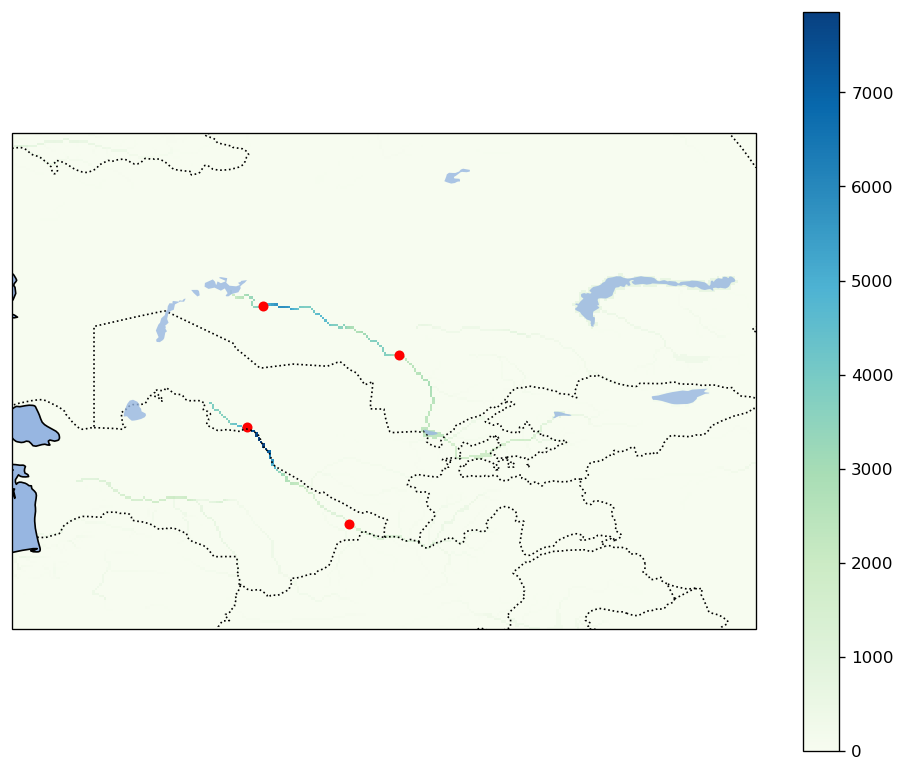

In [16]:
# Use matplotlib to make the figure slightly nicer
fig = plt.figure(figsize=(10,8),dpi=120)
#plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection=crs.PlateCarree())

# Plotting the model field is a one-liner
reference.get_value_as_xarray("discharge").plot(ax=ax, cmap="GnBu")

# Also plot the station location
ax.scatter(Chatly_station_longitude+1, Chatly_station_latitude-0.5, s=25, c="r", label = "Chatly")
ax.scatter(Kerki_station_longitude, Kerki_station_latitude, s=25, c="r", label = "Kerki")
ax.scatter(Tyumen_station_longitude, Tyumen_station_latitude, s=25, c="r", label = "Tyumen")
ax.scatter(Kazalinsk_station_longitude, Kazalinsk_station_latitude, s=25, c="r", label= "Kazalinsk")

# Overlay ocean and coastines
ax.add_feature(cfeature.OCEAN, zorder=2)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.8)
#ax.add_feature(cfeature.RIVERS)
#ax.add_feature(cfeature.RIVERS, zorder=2, color="k")
ax.coastlines(zorder=3)


In [17]:
reference.finalize()

## no agri


In [19]:
scenario_no_agri = ewatercycle.models.PCRGlobWB(
    parameter_set=parameter_set_no_agri,
    forcing=forcing
)

print(scenario_no_agri)

PCRGlobWB(
    parameter_set=ParameterSet(
        name='custom_parameter_set',
        directory=PosixPath('/data/shared/parameter-sets/pcrglobwb_global'),
        config=PosixPath('/home/avandervee3/MSc_AralSea/book/thesis_projects/MSc/2025_Q1_AndreVanDerVeen_CEG/work_i
n_progress/Comparison/Reference_05min_no_agri.ini'),
        doi='N/A',
        target_model='pcrglobwb',
        supported_model_versions={'setters'},
        downloader=None
    ),
    forcing=PCRGlobWBForcing(
        start_time='2004-01-01T00:00:00Z',
        end_time='2019-12-31T00:00:00Z',
        directory=PosixPath('/home/avandervee3/MSc_AralSea/book/thesis_projects/MSc/2025_Q1_AndreVanDerVeen_CEG/wor
k_in_progress/Test_Aral/forcing_0419/AralSeaBasin/pcrglobwb/work/diagnostic/script'),
        shape=PosixPath('/home/avandervee3/MSc_AralSea/book/thesis_projects/MSc/2025_Q1_AndreVanDerVeen_CEG/work_in
_progress/Test_Aral/forcing_0419/AralSeaBasin/pcrglobwb/work/diagnostic/script/AralSeaBasin.shp'),
        filenames={},
        precipitationNC='pcrglobwb_OBS6_ERA5_reanaly_1_day_pr_2004-2019_AralSeaBasin.nc',
        temperatureNC='pcrglobwb_OBS6_ERA5_reanaly_1_day_tas_2004-2019_AralSeaBasin.nc'
    )
)

In [20]:
scenario_no_agri_config, scenario_no_agri_dir = scenario_no_agri.setup(
    start_time = experiment_start_date,
    end_time = experiment_end_date,
    max_spinups_in_years=0
)
scenario_no_agri_config, scenario_no_agri_dir

('/home/avandervee3/MSc_AralSea/book/thesis_projects/MSc/2025_Q1_AndreVanDerVeen_CEG/work_in_progress/Comparison/pcrglobwb_20251024_143720/pcrglobwb_ewatercycle.ini',
 '/home/avandervee3/MSc_AralSea/book/thesis_projects/MSc/2025_Q1_AndreVanDerVeen_CEG/work_in_progress/Comparison/pcrglobwb_20251024_143720')

In [21]:


# Convert ISO 8601 strings to datetime objects
start_time = datetime.strptime(experiment_start_date, '%Y-%m-%dT%H:%M:%SZ')
end_time = datetime.strptime(experiment_end_date, '%Y-%m-%dT%H:%M:%SZ')

# Calculate the number of days for the progression bar
delta = end_time - start_time
number_of_days = delta.days
print(f"Number of days to model: {number_of_days}")

Number of days to model: 90

In [22]:
scenario_no_agri.initialize(scenario_no_agri_config)

In [ ]:
time = pd.date_range(scenario_no_agri.start_time_as_isostr, scenario_no_agri.end_time_as_isostr)
# timeseries = pd.DataFrame(
#     index=pd.Index(time, name="time"), columns=["reference", "experiment1", "experiment2"]
# )
# timeseries.head()

AttributeError: 'PCRGlobWB' object has no attribute '_bmi'

In [24]:
# Progress bar, since this can take a while
g = IntProgress(min=0, max=number_of_days) # instantiate the bar
display(g) # display the bar

while scenario_no_agri.time < scenario_no_agri.end_time:

    scenario_no_agri.update()

    # Track discharge at station location
    discharge_at_Chatly = scenario_no_agri.get_value_at_coords(
        "discharge", lat=[Chatly_station_latitude], lon=[Chatly_station_longitude]
    )
    time = scenario_no_agri.time_as_isostr
    Stations_timeseries_experiment_no_agri.loc[time, "Chatly"] = discharge_at_Chatly[0]

     # Track discharge at station location Kerki
    discharge_at_Kerki = scenario_no_agri.get_value_at_coords(
        "discharge", lat=[Kerki_station_latitude], lon=[Kerki_station_longitude]
    )
    time = scenario_no_agri.time_as_isostr
    Stations_timeseries_experiment_no_agri.loc[time, "Kerki"] = discharge_at_Kerki[0]

    # Track discharge at station Tyumen
    discharge_at_Tyumen = scenario_no_agri.get_value_at_coords(
        "discharge", lat=[Tyumen_station_latitude], lon=[Tyumen_station_longitude]
    )
    time = scenario_no_agri.time_as_isostr
    Stations_timeseries_experiment_no_agri.loc[time, "Tyumen"] = discharge_at_Tyumen[0]

    # Track discharge at station location Karalinsk
    discharge_at_Kazalinsk = scenario_no_agri.get_value_at_coords(
        "discharge", lat=[Kazalinsk_station_latitude], lon=[Kazalinsk_station_longitude]
    )
    time = scenario_no_agri.time_as_isostr
    Stations_timeseries_experiment_no_agri.loc[time, "Kazalinsk"] = discharge_at_Kazalinsk[0]


    g.value += 1

print("Model run finished!")

IntProgress(value=0, max=90)

Model run finished!

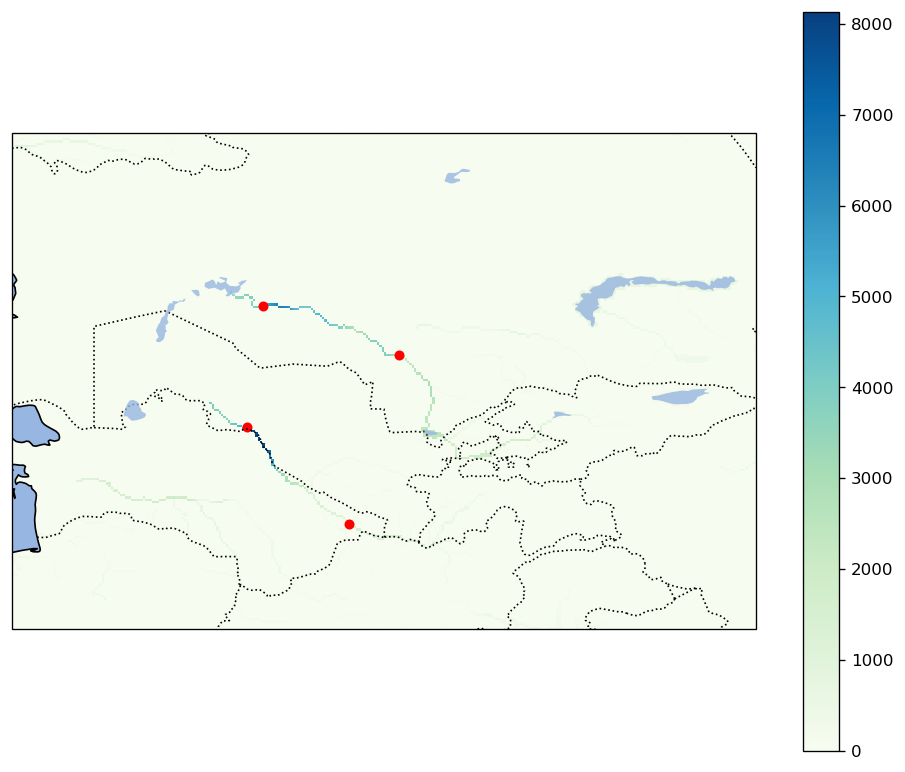

In [25]:
# Use matplotlib to make the figure slightly nicer
fig = plt.figure(figsize=(10,8),dpi=120)
#plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection=crs.PlateCarree())

# Plotting the model field is a one-liner
scenario_no_agri.get_value_as_xarray("discharge").plot(ax=ax, cmap="GnBu")

# Also plot the station location
ax.scatter(Chatly_station_longitude+1, Chatly_station_latitude-0.5, s=25, c="r", label = "Chatly")
ax.scatter(Kerki_station_longitude, Kerki_station_latitude, s=25, c="r", label = "Kerki")
ax.scatter(Tyumen_station_longitude, Tyumen_station_latitude, s=25, c="r", label = "Tyumen")
ax.scatter(Kazalinsk_station_longitude, Kazalinsk_station_latitude, s=25, c="r", label= "Kazalinsk")

# Overlay ocean and coastines
ax.add_feature(cfeature.OCEAN, zorder=2)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.8)
#ax.add_feature(cfeature.RIVERS)
#ax.add_feature(cfeature.RIVERS, zorder=2, color="k")
ax.coastlines(zorder=3)


In [26]:
scenario_no_agri.finalize()

## RoutingWave


In [29]:
scenario_RoutingWave = ewatercycle.models.PCRGlobWB(
    parameter_set=parameter_set_RoutingWave,
    forcing=forcing
)

print(scenario_RoutingWave)

PCRGlobWB(
    parameter_set=ParameterSet(
        name='custom_parameter_set',
        directory=PosixPath('/data/shared/parameter-sets/pcrglobwb_global'),
        config=PosixPath('/home/avandervee3/MSc_AralSea/book/thesis_projects/MSc/2025_Q1_AndreVanDerVeen_CEG/work_i
n_progress/Comparison/Reference_05min_RoutingWave.ini'),
        doi='N/A',
        target_model='pcrglobwb',
        supported_model_versions={'setters'},
        downloader=None
    ),
    forcing=PCRGlobWBForcing(
        start_time='2004-01-01T00:00:00Z',
        end_time='2019-12-31T00:00:00Z',
        directory=PosixPath('/home/avandervee3/MSc_AralSea/book/thesis_projects/MSc/2025_Q1_AndreVanDerVeen_CEG/wor
k_in_progress/Test_Aral/forcing_0419/AralSeaBasin/pcrglobwb/work/diagnostic/script'),
        shape=PosixPath('/home/avandervee3/MSc_AralSea/book/thesis_projects/MSc/2025_Q1_AndreVanDerVeen_CEG/work_in
_progress/Test_Aral/forcing_0419/AralSeaBasin/pcrglobwb/work/diagnostic/script/AralSeaBasin.shp'),
        filenames={},
        precipitationNC='pcrglobwb_OBS6_ERA5_reanaly_1_day_pr_2004-2019_AralSeaBasin.nc',
        temperatureNC='pcrglobwb_OBS6_ERA5_reanaly_1_day_tas_2004-2019_AralSeaBasin.nc'
    )
)

In [30]:
scenario_RoutingWave_config, scenario_RoutingWave_dir = scenario_RoutingWave.setup(
    start_time = experiment_start_date,
    end_time = experiment_end_date,
    max_spinups_in_years=0
)
scenario_RoutingWave_config, scenario_RoutingWave_dir

('/home/avandervee3/MSc_AralSea/book/thesis_projects/MSc/2025_Q1_AndreVanDerVeen_CEG/work_in_progress/Comparison/pcrglobwb_20251024_144912/pcrglobwb_ewatercycle.ini',
 '/home/avandervee3/MSc_AralSea/book/thesis_projects/MSc/2025_Q1_AndreVanDerVeen_CEG/work_in_progress/Comparison/pcrglobwb_20251024_144912')

In [31]:


# Convert ISO 8601 strings to datetime objects
start_time = datetime.strptime(experiment_start_date, '%Y-%m-%dT%H:%M:%SZ')
end_time = datetime.strptime(experiment_end_date, '%Y-%m-%dT%H:%M:%SZ')

# Calculate the number of days for the progression bar
delta = end_time - start_time
number_of_days = delta.days
print(f"Number of days to model: {number_of_days}")

Number of days to model: 90

In [32]:
scenario_RoutingWave.initialize(scenario_RoutingWave_config)

In [33]:
time = pd.date_range(scenario_RoutingWave.start_time_as_isostr, scenario_RoutingWave.end_time_as_isostr)

In [34]:
# Progress bar, since this can take a while
h = IntProgress(min=0, max=number_of_days) # instantiate the bar
display(h) # display the bar

while scenario_RoutingWave.time < scenario_RoutingWave.end_time:

    scenario_RoutingWave.update()

    # Track discharge at station location
    discharge_at_Chatly = scenario_RoutingWave.get_value_at_coords(
        "discharge", lat=[Chatly_station_latitude], lon=[Chatly_station_longitude]
    )
    time = scenario_RoutingWave.time_as_isostr
    Stations_timeseries_experiment_RoutingWave.loc[time, "Chatly"] = discharge_at_Chatly[0]

     # Track discharge at station location Kerki
    discharge_at_Kerki = scenario_RoutingWave.get_value_at_coords(
        "discharge", lat=[Kerki_station_latitude], lon=[Kerki_station_longitude]
    )
    time = scenario_RoutingWave.time_as_isostr
    Stations_timeseries_experiment_RoutingWave.loc[time, "Kerki"] = discharge_at_Kerki[0]

    # Track discharge at station Tyumen
    discharge_at_Tyumen = scenario_RoutingWave.get_value_at_coords(
        "discharge", lat=[Tyumen_station_latitude], lon=[Tyumen_station_longitude]
    )
    time = scenario_RoutingWave.time_as_isostr
    Stations_timeseries_experiment_RoutingWave.loc[time, "Tyumen"] = discharge_at_Tyumen[0]

    # Track discharge at station location Karalinsk
    discharge_at_Kazalinsk = scenario_RoutingWave.get_value_at_coords(
        "discharge", lat=[Kazalinsk_station_latitude], lon=[Kazalinsk_station_longitude]
    )
    time = scenario_RoutingWave.time_as_isostr
    Stations_timeseries_experiment_RoutingWave.loc[time, "Kazalinsk"] = discharge_at_Kazalinsk[0]


    h.value += 1

print("Model run finished!")

IntProgress(value=0, max=90)

Model run finished!

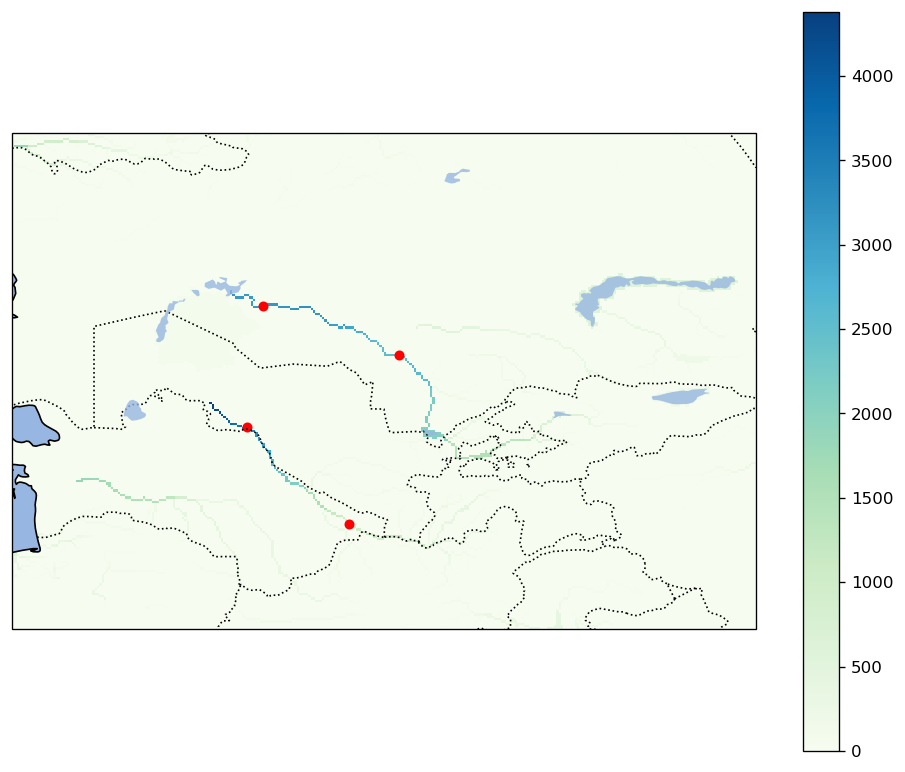

In [35]:
# Use matplotlib to make the figure slightly nicer
fig = plt.figure(figsize=(10,8),dpi=120)
#plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection=crs.PlateCarree())

# Plotting the model field is a one-liner
scenario_RoutingWave.get_value_as_xarray("discharge").plot(ax=ax, cmap="GnBu")

# Also plot the station location
ax.scatter(Chatly_station_longitude+1, Chatly_station_latitude-0.5, s=25, c="r", label = "Chatly")
ax.scatter(Kerki_station_longitude, Kerki_station_latitude, s=25, c="r", label = "Kerki")
ax.scatter(Tyumen_station_longitude, Tyumen_station_latitude, s=25, c="r", label = "Tyumen")
ax.scatter(Kazalinsk_station_longitude, Kazalinsk_station_latitude, s=25, c="r", label= "Kazalinsk")

# Overlay ocean and coastines
ax.add_feature(cfeature.OCEAN, zorder=2)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.8)
#ax.add_feature(cfeature.RIVERS)
#ax.add_feature(cfeature.RIVERS, zorder=2, color="k")
ax.coastlines(zorder=3)


In [36]:
scenario_RoutingWave.finalize()

In [38]:
Stations_timeseries_experiment_RoutingWave.to_csv("RoutingWave.csv", index=False)
Stations_timeseries_experiment_no_agri.to_csv("Scenario_no_agri.csv", index=False)
Stations_timeseries.to_csv("Reference.csv", index=False)

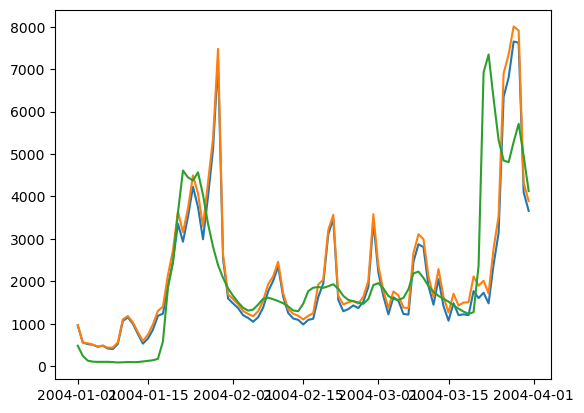

In [39]:
plt.plot(Stations_timeseries["Chatly"])
plt.plot(Stations_timeseries_experiment_no_agri["Chatly"])
plt.plot(Stations_timeseries_experiment_RoutingWave["Chatly"])